In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.utils import shuffle

In [3]:
# read in the data
x = pd.read_csv('X.csv',  header=None)
y = pd.read_csv('y.csv',  header=None)

# concatenate x and y
df = pd.concat([x, y], axis=1)

# shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

# randomly partition the data into 10 groups.
x = []
y = []
for i in range(10):
    x.append(df.iloc[460*i:460*i+460,:-1])
    y.append(df.iloc[460*i:460*i+460,-1])

In [4]:
def steepest_ascent(x, y):
    # initialize the objective list
    objective_all = []
    eta = 0.01/4600
    accuracy = 4600
    
    for i in range(10):
        objective = []
        
        # manipulate the data for the purpose of logistic regression
        tmp_x = x.copy()
        tmp_y = y.copy()
        x_test = tmp_x.pop(i).values
        y_test = tmp_y.pop(i).values
        x_train = pd.concat(tmp_x).values
        y_train = pd.concat(tmp_y).values
        
        # add a constant column for x 
        x_train=np.insert(x_train, 54, 1, axis=1)
        x_test=np.insert(x_test, 54, 1, axis=1)
        
        # change y = 0 to y = -1 for classification
        y_train[np.where(y_train == 0)] = -1
        y_test[np.where(y_test == 0)] = -1
        
        # initialize w
        w = np.zeros(len(x_train[0]))
        
        # run steepest ascent for 1000 times
        for j in range(1000):
            sigmoid = np.exp((y_train * x_train.T).T @ w)/\
            (1 + np.exp((y_train * x_train.T).T @ w))
            w = w + eta * (np.sum((1-sigmoid).reshape(-1,1) * 
                                  (y_train * x_train.T).T, axis=0))
            objective.append(np.sum(sigmoid))
        objective_all.append(objective)
        
        # make predictions
        prediction = w @ x_test.T
        prediction[np.where(prediction > 0)] = 1
        prediction[np.where(prediction < 0)] = -1
        accuracy -= np.sum(abs(prediction - y_test))
    print('accuracy: {}'.format(np.round(accuracy/4600.0, 3)))    
    return objective_all

In [5]:
objective_all = steepest_ascent(x, y)


accuracy: 0.857


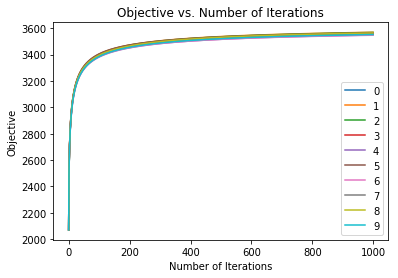

In [6]:
x_axis = np.arange(1000)
for i in range(len(objective_all)):
    plt.plot(x_axis, objective_all[i], label=i)
plt.title('Objective vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Objective')
plt.legend()
plt.show()

# “Newton’s method” for logistic regression

In [7]:
def newtons_method(x, y):
    # initialize the objective list
    objective_all = []
    a = []
    for i in range(55):
        a.append(0.01)
    b = np.diag(a)
    
    # initialize the four values we need to return 
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i in range(10):
        objective = []
        
        # manipulate the data for the purpose of logistic regression
        tmp_x = x.copy()
        tmp_y = y.copy()
        x_test = tmp_x.pop(i).values
        y_test = tmp_y.pop(i).values
        x_train = pd.concat(tmp_x).values
        y_train = pd.concat(tmp_y).values
        
        # add a constant column for x 
        x_train=np.insert(x_train, 54, 1, axis=1)
        x_test=np.insert(x_test, 54, 1, axis=1)
        
        # change y = 0 to y = -1 for classification
        y_train[np.where(y_train == 0)] = -1
        y_test[np.where(y_test == 0)] = -1
        
        # initialize w, sigmoid function and objective L
        w = np.zeros(len(x_train[0]))
        sigmoid = np.exp((y_train * x_train.T).T @ w)/\
            (1 + np.exp((y_train * x_train.T).T @ w))
        L = np.sum(np.log(sigmoid))
        
        # run newton's method for 100 times
        for j in range(100):
            gradient = np.sum((1-sigmoid).reshape(-1,1) * 
                                  (y_train * x_train.T).T, axis=0)
            
            diagonal = np.diag(sigmoid * (1-sigmoid).reshape(-1,1))
            hessian = -  x_train.T * diagonal @ x_train - (10**(-2))*np.identity(55)
            w = w - (gradient.T @ np.linalg.inv(hessian)).T
            sigmoid = np.exp((y_train * x_train.T).T @ w)/\
            (1 + np.exp((y_train * x_train.T).T @ w))
            L +=  - (gradient.T @ np.linalg.inv(hessian)) @ gradient + 0.5 * \
            (gradient.T @ np.linalg.inv(hessian)) @ hessian @ (gradient.T @ np.linalg.inv(hessian)).T
            objective.append(L)
        objective_all.append(objective)
        # make predictions
        prediction = w @ x_test.T
        prediction[np.where(prediction > 0)] = 1
        prediction[np.where(prediction < 0)] = -1
        for i in range(len(prediction)):
            if prediction[i] == y_test[i] and prediction[i] == 1:
                true_positive += 1
            elif prediction[i] == y_test[i] and prediction[i] == -1:
                true_negative += 1
            elif prediction[i] != y_test[i] and prediction[i] == 1:
                false_positive += 1
            else:
                false_negative += 1
                    
                
    accuracy = (true_positive + true_negative)/\
    (true_positive + true_negative + false_positive + false_negative)
    print('accuracy: {}'.format(np.round(accuracy, 3)))
    df = pd.DataFrame([[true_negative, false_positive], 
                       [false_negative, true_positive]], 
                      index=['True Negative', 'True Positive'], 
                      columns=['Predicted Negative', 'Predicted Positive'])
    print(df)
    return objective_all

In [8]:
newton_objective = newtons_method(x, y)


accuracy: 0.924
               Predicted Negative  Predicted Positive
True Negative                2645                 142
True Positive                 207                1606


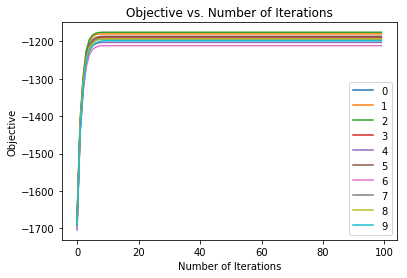

In [9]:
x_axis = np.arange(100)
for i in range(len(newton_objective)):
    plt.plot(x_axis, newton_objective[i], label=i)
plt.title('Objective vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Objective')
plt.legend()
plt.show()

In [10]:
newton_objective = newtons_method(x, y)


accuracy: 0.924
               Predicted Negative  Predicted Positive
True Negative                2645                 142
True Positive                 207                1606
